This file runs a 

In [4]:
import pickle
import helpsk as hlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder  # , LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
# from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

# Load Data

In [23]:
parser = hlp.sklearn_eval.SearchCVParser.from_yaml_file(yaml_file_name = 'Run 1 - Random Forest - BayesSearchCV.yaml')
parser.best_primary_score_params()

{'max_features': 0.013557701109648362,
 'n_estimators': 4098,
 'encoder': 'CustomOrdinalEncoder()',
 'imputer': 'SimpleImputer()',
 'scaler': 'StandardScaler()'}

In [8]:
with open('../X_train.pkl', 'rb') as handle:
    X_train = pickle.load(handle)
    print(X_train.shape)

with open('../y_train.pkl', 'rb') as handle:
    y_train = pickle.load(handle)
    print(len(y_train))

with open('../X_test.pkl', 'rb') as handle:
    X_test = pickle.load(handle)
    print(X_test.shape)

with open('../y_test.pkl', 'rb') as handle:
    y_test = pickle.load(handle)
    print(len(y_test))

(800, 20)
800
(200, 20)
200


In [10]:
X_train.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
29,NaN,NaN,delayed previously,business,0.0,<100,>=7,3.0,male single,none,4.0,no known property,63.0,none,own,2.0,skilled,1.0,yes,yes
535,>=200,21.0,critical/other existing credit,education,2319.0,<100,<1,2.0,male div/sep,none,1.0,car,33.0,none,rent,1.0,skilled,1.0,none,yes
695,no checking,6.0,existing paid,used car,1236.0,500<=X<1000,1<=X<4,2.0,male single,none,4.0,life insurance,50.0,none,rent,1.0,skilled,1.0,none,yes
557,no checking,21.0,no credits/all paid,new car,5003.0,no known savings,1<=X<4,1.0,female div/dep/mar,none,4.0,life insurance,29.0,bank,own,2.0,skilled,1.0,yes,yes
836,no checking,12.0,existing paid,radio/tv,886.0,no known savings,1<=X<4,4.0,female div/dep/mar,none,2.0,car,21.0,none,own,1.0,skilled,1.0,none,yes


In [11]:
y_train[0:10]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [14]:
X_test.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
521,<0,18.0,existing paid,radio/tv,3190.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,24.0,none,own,1.0,skilled,1.0,none,yes
737,<0,18.0,existing paid,new car,4380.0,100<=X<500,1<=X<4,3.0,male single,none,4.0,car,35.0,none,own,1.0,unskilled resident,2.0,yes,yes
740,<0,24.0,all paid,new car,2325.0,100<=X<500,4<=X<7,2.0,male single,none,3.0,car,32.0,bank,own,1.0,skilled,1.0,none,yes
660,>=200,12.0,existing paid,radio/tv,1297.0,<100,1<=X<4,3.0,male mar/wid,none,4.0,real estate,23.0,none,rent,1.0,skilled,1.0,none,yes
411,no checking,33.0,critical/other existing credit,used car,7253.0,<100,4<=X<7,3.0,male single,none,2.0,car,35.0,none,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes


In [13]:
y_test[0:10]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Training and Test Data

In [31]:
y_train[0:10]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [33]:
numeric_columns = hlp.pandas.get_numeric_columns(X_train)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(X_train)
print(numeric_columns)
print(non_numeric_columns)

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [34]:
parser.best_primary_score_params()

{'max_features': 0.013557701109648362,
 'n_estimators': 4098,
 'encoder': 'CustomOrdinalEncoder()',
 'imputer': 'SimpleImputer()',
 'scaler': 'StandardScaler()'}

In [35]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

In [36]:
non_numeric_pipeline = Pipeline([
    ('encoder', hlp.sklearn_pipeline.CustomOrdinalEncoder()),
])

In [37]:
from sklearn.compose import ColumnTransformer
transformations_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('non_numeric', non_numeric_pipeline, non_numeric_columns)
])

# Model

In [38]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(
    max_features=0.013557701109648362,
    n_estimators=4098,
    random_state=42,
)

In [39]:
full_pipeline = Pipeline([
    ('prep', transformations_pipeline),
    ('model', random_forest_model)
])

In [30]:
# Show the levels of pipelines/transformers/model
full_pipeline.named_steps

{'prep': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', StandardScaler())]),
                                  ['duration', 'credit_amount',
                                   'installment_commitment', 'residence_since',
                                   'age', 'existing_credits',
                                   'num_dependents']),
                                 ('non_numeric',
                                  Pipeline(steps=[('encoder',
                                                   CustomOrdinalEncoder())]),
                                  ['checking_status', 'credit_history',
                                   'purpose', 'savings_status', 'employment',
                                   'personal_status', 'other_parties',
                                   'property_magnitude', 'other_payment_plans',
                                  

In [41]:
fitted_pipeline = full_pipeline.fit(X_train, y_train)

In [43]:
fitted_pipeline.predict(X_test)

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1])

In [45]:
fitted_pipeline.predict_proba(X_test)

array([[0.43728648, 0.56271352],
       [0.363592  , 0.636408  ],
       [0.62518302, 0.37481698],
       [0.3340654 , 0.6659346 ],
       [0.14812103, 0.85187897],
       [0.33308931, 0.66691069],
       [0.09736457, 0.90263543],
       [0.42118106, 0.57881894],
       [0.11957052, 0.88042948],
       [0.20107369, 0.79892631],
       [0.18033187, 0.81966813],
       [0.42240117, 0.57759883],
       [0.21864324, 0.78135676],
       [0.579551  , 0.420449  ],
       [0.70644217, 0.29355783],
       [0.34407028, 0.65592972],
       [0.19082479, 0.80917521],
       [0.16569058, 0.83430942],
       [0.5170815 , 0.4829185 ],
       [0.29892631, 0.70107369],
       [0.27769644, 0.72230356],
       [0.26500732, 0.73499268],
       [0.12298682, 0.87701318],
       [0.02244998, 0.97755002],
       [0.06149341, 0.93850659],
       [0.40263543, 0.59736457],
       [0.5295266 , 0.4704734 ],
       [0.40605173, 0.59394827],
       [0.27745242, 0.72254758],
       [0.20497804, 0.79502196],
       [0.

In [44]:
y_test

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1])

## Training Set Evaluation

Understand the nature/degree of model overfitting by comparing to `Test Set Evaluation`

In [46]:
predicted_scores = fitted_pipeline.predict_proba(X_train)[:, 1]

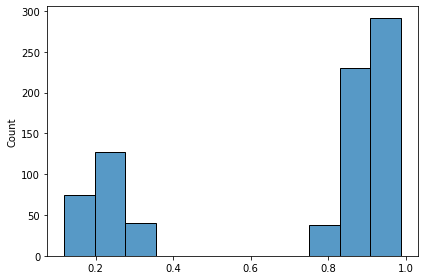

In [48]:
sns.histplot(predicted_scores)
plt.tight_layout()

In [49]:

evaluator = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_train,
    predicted_scores=predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)

In [50]:
evaluator.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,1.000,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,1.000,"100.0% of positive instances were correctly identified.; i.e. 559 ""Good"" labels were correctly identified out of 559 instances; a.k.a Sensitivity/Recall"
True Negative Rate,1.000,"100.0% of negative instances were correctly identified.; i.e. 241 ""Bad"" labels were correctly identified out of 241 instances"
False Positive Rate,0.000,"0.0% of negative instances were incorrectly identified as positive; i.e. 0 ""Bad"" labels were incorrectly identified as ""Good"", out of 241 instances"
False Negative Rate,0.000,"0.0% of positive instances were incorrectly identified as negative; i.e. 0 ""Good"" labels were incorrectly identified as ""Bad"", out of 559 instances"
Positive Predictive Value,1.000,"When the model claims an instance is positive, it is correct 100.0% of the time; i.e. out of the 559 times the model predicted ""Good"", it was correct 559 times; a.k.a precision"
Negative Predictive Value,1.000,"When the model claims an instance is negative, it is correct 100.0% of the time; i.e. out of the 241 times the model predicted ""Bad"", it was correct 241 times"
F1 Score,1.000,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,1.000,100.0% of instances were correctly identified
Error Rate,0.000,0.0% of instances were incorrectly identified


In [51]:
del predicted_scores

## Test Set Evaluation

In [52]:
predicted_scores = fitted_pipeline.predict_proba(X_test)[:, 1]

In [54]:
predicted_scores[0:10]

array([0.56271352, 0.636408  , 0.37481698, 0.6659346 , 0.85187897,
       0.66691069, 0.90263543, 0.57881894, 0.88042948, 0.79892631])

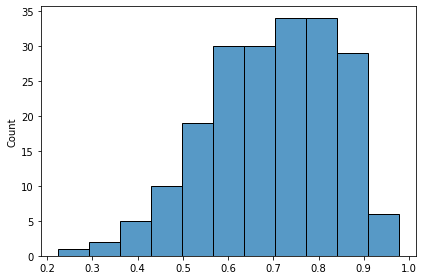

In [55]:
sns.histplot(predicted_scores)
plt.tight_layout()

In [56]:
y_test_cat = pd.Series(y_test).replace({1: 'Defaulted', 0: 'Not Defaulted'})
y_test_cat.head()

0    Not Defaulted
1        Defaulted
2        Defaulted
3        Defaulted
4        Defaulted
dtype: object

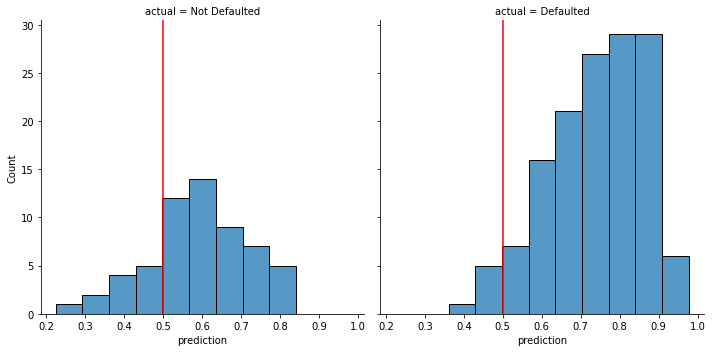

In [57]:
axes = sns.displot(
    pd.DataFrame({
        'prediction': predicted_scores,
        'actual': y_test_cat
    }),
    x='prediction',
    col='actual'
)
for axis in axes.axes.flat:
    axis.axvline(x=0.5, ymin=0, ymax=100, color='red')
plt.tight_layout()

In [82]:
del y_test_cat
del axes

In [58]:
evaluator = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)

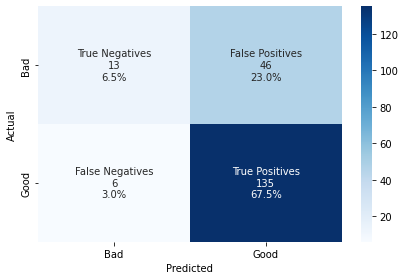

In [59]:
evaluator.plot_confusion_matrix()

In [60]:
evaluator.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.801,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,0.957,"95.7% of positive instances were correctly identified.; i.e. 135 ""Good"" labels were correctly identified out of 141 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.220,"22.0% of negative instances were correctly identified.; i.e. 13 ""Bad"" labels were correctly identified out of 59 instances"
False Positive Rate,0.780,"78.0% of negative instances were incorrectly identified as positive; i.e. 46 ""Bad"" labels were incorrectly identified as ""Good"", out of 59 instances"
False Negative Rate,0.043,"4.3% of positive instances were incorrectly identified as negative; i.e. 6 ""Good"" labels were incorrectly identified as ""Bad"", out of 141 instances"
Positive Predictive Value,0.746,"When the model claims an instance is positive, it is correct 74.6% of the time; i.e. out of the 181 times the model predicted ""Good"", it was correct 135 times; a.k.a precision"
Negative Predictive Value,0.684,"When the model claims an instance is negative, it is correct 68.4% of the time; i.e. out of the 19 times the model predicted ""Bad"", it was correct 13 times"
F1 Score,0.839,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.740,74.0% of instances were correctly identified
Error Rate,0.260,26.0% of instances were incorrectly identified


Compare results against scores if we predicted all `Good`

In [61]:
dummy_predicted_scores = np.array([0.99] * len(predicted_scores))

In [62]:
dummy_eval = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=dummy_predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)
dummy_eval.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.500,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,1.000,"100.0% of positive instances were correctly identified.; i.e. 141 ""Good"" labels were correctly identified out of 141 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.000,"0.0% of negative instances were correctly identified.; i.e. 0 ""Bad"" labels were correctly identified out of 59 instances"
False Positive Rate,1.000,"100.0% of negative instances were incorrectly identified as positive; i.e. 59 ""Bad"" labels were incorrectly identified as ""Good"", out of 59 instances"
False Negative Rate,0.000,"0.0% of positive instances were incorrectly identified as negative; i.e. 0 ""Good"" labels were incorrectly identified as ""Bad"", out of 141 instances"
Positive Predictive Value,0.705,"When the model claims an instance is positive, it is correct 70.5% of the time; i.e. out of the 200 times the model predicted ""Good"", it was correct 141 times; a.k.a precision"
Negative Predictive Value,0.000,"When the model claims an instance is negative, it is correct 0.0% of the time; i.e. out of the 0 times the model predicted ""Bad"", it was correct 0 times"
F1 Score,0.827,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.705,70.5% of instances were correctly identified
Error Rate,0.295,29.5% of instances were incorrectly identified


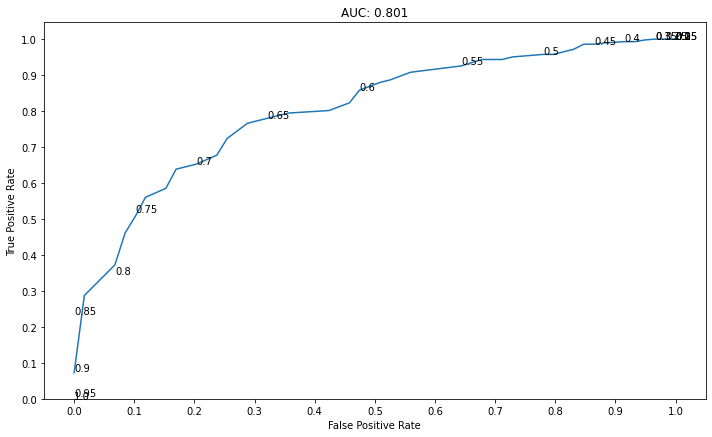

In [63]:
evaluator.plot_auc_curve()
plt.grid()

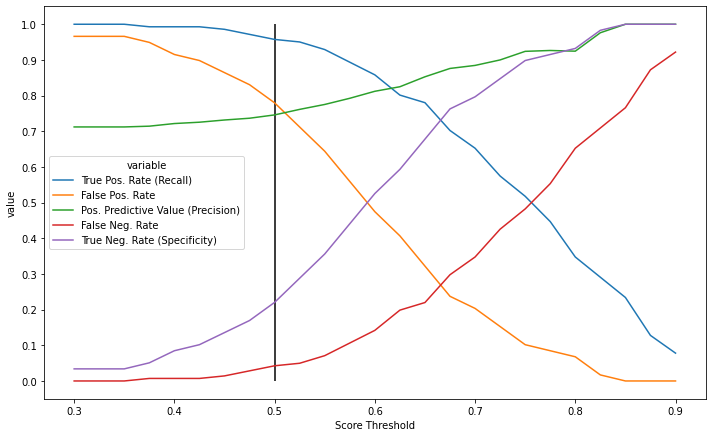

In [64]:
evaluator.plot_threshold_curves()
plt.grid()

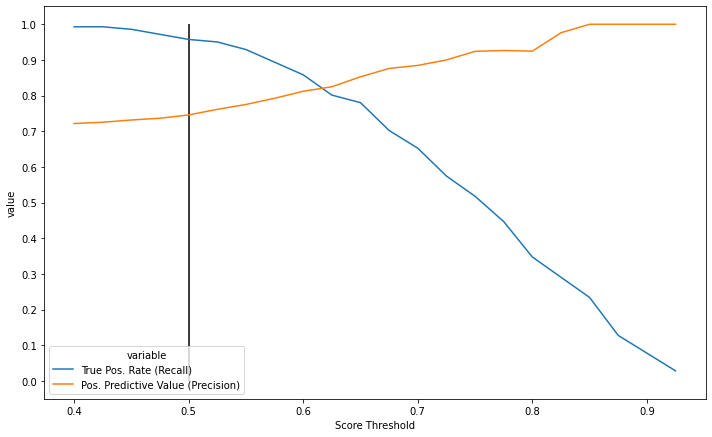

In [65]:
evaluator.plot_precision_recall_tradeoff(score_threshold_range=(0.4, 0.95))
plt.grid()

In [66]:
evaluator.calculate_lift_gain(return_style=True, include_all_info=True)

,# of Obs.,# of Pos. Events,Cumul. Pos. Events,Gain,Lift
Percentile,,,,,
5,9,9,9,0.06,1.28
10,11,11,20,0.14,1.42
15,10,10,30,0.21,1.42
20,10,9,39,0.28,1.38
25,10,7,46,0.33,1.30
30,10,10,56,0.40,1.32
35,10,9,65,0.46,1.32
40,10,9,74,0.52,1.31
45,10,7,81,0.57,1.28


In [67]:
del predicted_scores

## Feature Importance

todo: how to get features names out of final_estimator?

https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer

```
clf.named_steps['preparation'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)
```

In [69]:
new_non_numeric_columns = full_pipeline.named_steps['preparation'].transformers_[1][1].named_steps['encoder'].get_feature_names_out()
new_non_numeric_columns = list(new_non_numeric_columns)

NameError: name 'full_pipeline' is not defined

In [104]:
len(new_non_numeric_columns)

55

In [105]:
len(final_model.feature_importances_)

62

In [106]:
final_column_names = numeric_columns + new_non_numeric_columns

In [107]:
pd.DataFrame({
    'importance (final)': final_model.feature_importances_,
    'importance (cross val)': grid_search.best_estimator_._final_estimator.feature_importances_
    
}, index=final_column_names).\
sort_values(by='importance (final)', ascending=False).\
style.bar(color=hlp.color.GRAY, vmin=0)

,importance (final),importance (cross val)
credit_amount,0.104054,0.081767
age,0.084570,0.072054
duration,0.074995,0.063923
checking_status_no checking,0.047417,0.033809
checking_status_<0,0.040988,0.033009
installment_commitment,0.034824,0.038051
residence_since,0.032843,0.037222
credit_history_critical/other existing credit,0.022264,0.020246
savings_status_<100,0.020792,0.020250
purpose_new car,0.018736,0.018526


# TODO

- get feature importance for model that has various transformations (would have to build pipeline manually based on selected transformers since transformers are being tuned via grid-search)
    - https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214
    - https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
   
```
grid_search.best_estimator_._final_estimator.feature_importances_
grid_search.best_estimator_._final_estimator.feature_importances_.shape
```

right now we can get importances but can't get feature names since it is being

In [108]:
#grid_search.best_estimator_.named_steps['preparation'].transformers[1][1].named_steps['encoder'].transformer.get_feature_names()

In [109]:
grid_search.best_estimator_._final_estimator.feature_importances_

array([0.06392319, 0.08176671, 0.0380507 , 0.03722161, 0.07205391,
       0.02128217, 0.01135315, 0.01975279, 0.03300944, 0.00656691,
       0.03380932, 0.00601217, 0.00968149, 0.02024632, 0.00926076,
       0.01689088, 0.01231891, 0.01122847, 0.0028823 , 0.00874858,
       0.01408273, 0.01852644, 0.00232178, 0.01794846, 0.00393875,
       0.0012857 , 0.0097917 , 0.00945918, 0.00701141, 0.0202496 ,
       0.0060604 , 0.01293276, 0.01671606, 0.01361385, 0.01446542,
       0.01615652, 0.00922622, 0.01661636, 0.00602843, 0.00878087,
       0.01772468, 0.00559852, 0.00596786, 0.00940453, 0.01641875,
       0.01420544, 0.01289265, 0.01627603, 0.01343604, 0.01682256,
       0.00647033, 0.00979669, 0.01880648, 0.01291542, 0.01210869,
       0.01706706, 0.00274172, 0.0117306 , 0.01620724, 0.0158297 ,
       0.00347457, 0.00283206])

- future importance
    - https://www.kaggle.com/general/175075
        - LOFO (Leave one feature out) for feature importance.
    - https://explained.ai/rf-importance/